In [9]:
import os
import ast
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras.models import Sequential
from keras import backend as K

print(os.listdir("data"))

['test_simplified.csv', 'train_simplified.zip', 'train_simplified']


In [15]:
TRAIN_PATH = "data/train_simplified/"
TEST_PATH = "data/test_simplified.csv"
SUBMISSION_NAME = 'submission.csv'

In [35]:
train = pd.DataFrame()

for file in os.listdir(TRAIN_PATH):
    train = train.append(pd.read_csv(TRAIN_PATH + file, usecols = [1, 5], nrows = 1000))
train = shuffle(train, random_state=123)  

In [36]:
len(train)

340000

In [38]:
n_classes = train['word'].unique()
print(n_classes)

['laptop' 'belt' 'leg' 'mug' 'flower' 'school bus' 'snorkel' 'hospital'
 'beard' 'teapot' 'airplane' 'hockey stick' 'basket' 'campfire' 'wheel'
 'bracelet' 'lightning' 'banana' 'stitches' 'spoon' 'hat' 'ear'
 'hourglass' 'lantern' 'triangle' 'sock' 'cannon' 'diving board' 'octagon'
 'flamingo' 'candle' 'scissors' 'mushroom' 'tornado' 'pencil' 'owl'
 'train' 'screwdriver' 'arm' 'saxophone' 'mountain' 'frog' 'bicycle'
 'elbow' 'teddy-bear' 'blackberry' 'palm tree' 'giraffe' 'keyboard'
 'rollerskates' 'light bulb' 'apple' 'flashlight' 'elephant' 'nose'
 'lipstick' 'paint can' 'steak' 'traffic light' 'toe' 'saw' 'tent' 'cake'
 'mermaid' 'garden hose' 'bucket' 'stethoscope' 'bear' 'hedgehog'
 'underwear' 'eraser' 'fire hydrant' 'bread' 'ice cream' 'squirrel'
 'anvil' 'bush' 'bird' 'squiggle' 'mouth' 'toothpaste' 'suitcase'
 'soccer ball' 'parrot' 'frying pan' 'envelope' 'house plant' 'broccoli'
 'mosquito' 'television' 'knee' 'grapes' 'golf club' 'tractor' 'purse'
 'diamond' 'cow' 'telephon

In [5]:
# fixing label in the training set
train['word'] = train['word'].replace(' ', '_', regex=True)

# get labels and one-hot encode them.
n_classes = train['word'].unique()
labels = pd.get_dummies(train['word']).values
train.drop(['word'], axis=1, inplace=True)

print("Total number of labels: "+str(len(labels)))

Total number of labels: 340000


In [6]:
print(labels[1000])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


In [19]:
BASE_SIZE = 256
RE_SIZE = (70,70)

def datapoints_to_img(raw_strokes, size=256, lw=6, time_color=True):
    
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    return cv2.resize(img, RE_SIZE, interpolation=cv2.INTER_AREA)

In [8]:
#  training datapoints stacked in a list
drawings_train = [ast.literal_eval(pts) for pts in train['drawing'].values]
print(len(drawings_train))

340000


In [9]:
training_images = []
i = 0
for stroke in drawings_train:
    img = datapoints_to_img(stroke)
    training_images.append(img)
    print('processed {}/{}'.format(i+1,len(drawings_train)),end = '\r', flush=True)
    i+=1

In [10]:
training_images = np.array(training_images)

In [11]:
len(training_images)

340000

In [12]:
print(training_images.shape)

(340000, 70, 70)


In [13]:
np.save('training_images',training_images)
np.save('labels',labels)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(training_images, labels, test_size=0.1, random_state=1)

In [15]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((306000, 70, 70), (306000, 340), (34000, 70, 70), (34000, 340))

In [16]:
#save data
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_val',x_val)
np.save('y_val',y_val)

In [2]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

In [3]:
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')

In [4]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((306000, 70, 70), (306000, 340), (34000, 70, 70), (34000, 340))

In [ ]:
this = 500
plt.imshow(x_train[this], cmap='gray')

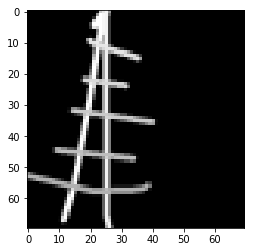

In [108]:
this = 1200
plt.imshow(x_val[this], cmap='gray')

In [5]:
img_rows = 70
img_cols = 70

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
print(input_shape)

(70, 70, 1)


In [110]:
# convert and normalize the data

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((306000, 70, 70, 1), (306000, 340), (34000, 70, 70, 1), (34000, 340))

In [7]:
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

x_train shape: (306000, 70, 70, 1)
x_val shape: (34000, 70, 70, 1)
306000 train samples
34000 test samples


In [113]:
# now feed it to the model

In [10]:
def get_model():
    
    input_layer=Input(shape=input_shape)
    
    x=Conv2D(filters=8,kernel_size=(5,5),padding='valid', activation='relu')(input_layer)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=16,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    x=Conv2D(filters=32,kernel_size=(3,3),padding='valid', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='valid')(x)
    
    
    x=Conv2D(filters=64,kernel_size=(3,3),padding='same', activation='relu')(x)
    x=MaxPool2D(pool_size=(2,2),strides=2,padding='same')(x)
    
    x=Flatten()(x)
    
    x=Dense(units=64)(x)
    x=Dense(units=340)(x) 
    output_layer=Activation('softmax')(x)
    
    model=Model(inputs=input_layer,outputs=output_layer)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    
    return model

model=get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70, 70, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 66, 66, 8)         208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
__________

In [11]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(306000, 70, 70, 1) (306000, 340) (34000, 70, 70, 1) (34000, 340)


In [12]:
#https://github.com/tajwarabraraleef/kaggle-quickdraw/blob/master/temp/read.py

In [13]:
path_model='google_quickdraw.h5' 
model=get_model() 
K.set_value(model.optimizer.lr,1e-3) # set the learning rate

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64,
            epochs=20,
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            callbacks=[
                ModelCheckpoint(filepath=path_model),
            ]
            )

Train on 306000 samples, validate on 34000 samples
Epoch 1/20
306000/306000 [==============================] - 933s 3ms/step - loss: 3.3216 - acc: 0.3002 - val_loss: 2.6002 - val_acc: 0.4111
Epoch 2/20
306000/306000 [==============================] - 920s 3ms/step - loss: 2.4413 - acc: 0.4415 - val_loss: 2.3698 - val_acc: 0.4546
Epoch 3/20
306000/306000 [==============================] - 924s 3ms/step - loss: 2.2686 - acc: 0.4754 - val_loss: 2.3080 - val_acc: 0.4696
Epoch 4/20
306000/306000 [==============================] - 914s 3ms/step - loss: 2.1851 - acc: 0.4909 - val_loss: 2.2331 - val_acc: 0.4829
Epoch 5/20
306000/306000 [==============================] - 923s 3ms/step - loss: 2.1345 - acc: 0.5018 - val_loss: 2.1984 - val_acc: 0.4912
Epoch 6/20
306000/306000 [==============================] - 924s 3ms/step - loss: 2.0988 - acc: 0.5085 - val_loss: 2.1733 - val_acc: 0.4961
Epoch 7/20
306000/306000 [==============================] - 922s 3ms/step - loss: 2.0741 - acc: 0.5130 - val_

In [16]:
test = pd.read_csv(TEST_PATH, usecols=[0, 2], nrows=None) # was 100 before
print(len(test))

112199


In [17]:
#  testing datapoints stacked in a list
drawings_test = [ast.literal_eval(pts) for pts in test['drawing'].values]
len(drawings_test)

112199

In [20]:
testing_images = []
i = 0
for stroke in drawings_test:
    img = datapoints_to_img(stroke)
    testing_images.append(img)
    print('processed {}/{}'.format(i+1,len(drawings_test)),end = '\r', flush=True)
    i+=1

In [21]:
len(testing_images)

112199

In [22]:
testing_images = np.array(testing_images)

In [25]:
if K.image_data_format() == 'channels_first':
    testing_images = testing_images.reshape(testing_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    testing_images = testing_images.reshape(testing_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [26]:
testing_images = testing_images.astype('float32')

In [27]:
testing_images.shape

(112199, 70, 70, 1)

In [28]:
np.save('testing_images',testing_images)

In [29]:
predictions = model.predict(testing_images)

In [30]:
print(len(predictions))

112199


In [32]:
x = np.argpartition(predictions[500], -3)[-3:]
print(x)

[322  48 182]


In [39]:
top_3_predictions = np.asarray([np.argpartition(pred, -3)[-3:] for pred in predictions])
top_3_predictions = ['%s %s %s' % (n_classes[pred[0]], n_classes[pred[1]], n_classes[pred[2]]) for pred in top_3_predictions]
test['word'] = top_3_predictions

In [40]:
len(top_3_predictions)

112199

In [42]:
print(top_3_predictions[102000])

eyeglasses screwdriver bicycle


In [43]:
submission = test[['key_id', 'word']]
submission.to_csv(SUBMISSION_NAME, index=False)
submission.head()

,key_id,word
0,9000003627287624,compass clarinet sink
1,9000010688666847,soccer ball saxophone waterslide
2,9000023642890129,bucket skateboard belt
3,9000038588854897,moustache megaphone fish
4,9000052667981386,crayon squirrel drums
